<a href="https://colab.research.google.com/github/UygarUsta/Test/blob/main/Facial_Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints


Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 5984, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5984 (delta 0), reused 0 (delta 0), pack-reused 5981
Receiving objects: 100% (5984/5984), 329.50 MiB | 50.19 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [4]:
root_dir = './P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

In [3]:
data = pd.read_csv("/content/P1_Facial_Keypoints/data/training_frames_keypoints.csv")
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [8]:
data.iloc[0,0] #Each person at index val

'Luis_Fonsi_21.jpg'

In [12]:
x_ax = np.array(data.iloc[0,1:][0::2]) #x axis keypoint values
y_ax = np.array(data.iloc[0,1:][1::2]) #y axis keypoint values

print(x_ax)
print("\n",y_ax)

[45.0 47.0 49.0 53.0 56.0 62.0 66.0 73.0 81.0 92.0 96.0 98.0 102.0 102.0
 104.0 104.0 102.0 51.0 56.0 60.0 64.0 68.0 83.0 87.0 92.0 96.0 100.0 77.0
 79.0 79.0 79.0 73.0 75.0 79.0 81.0 83.0 58.0 62.0 64.0 68.0 66.0 62.0
 85.0 87.0 92.0 94.0 92.0 87.0 68.0 73.0 77.0 79.0 81.0 85.0 90.0 87.0
 85.0 81.0 77.0 73.0 70.0 77.0 79.0 83.0 90.0 83.0 81.0 77.0]

 [98.0 106.0 110.0 119.0 125.0 130.0 134.0 136.0 139.0 134.0 130.0 126.0
 120.0 111.0 105.0 99.0 90.0 89.0 87.0 87.0 87.0 87.0 85.0 83.0 81.0 81.0
 84.0 92.0 98.0 102.0 107.0 109.0 109.0 111.0 109.0 109.0 94.0 92.0 92.0
 92.0 94.0 94.0 92.0 90.0 90.0 90.0 92.0 92.0 119.0 117.0 115.0 117.0
 115.0 117.0 117.0 122.0 124.0 124.0 124.0 121.0 119.0 119.0 119.0 119.0
 117.0 119.0 122.0 122.0]


In [15]:
len(x_ax) == len(y_ax)

True

In [47]:
class Faces(Dataset):
  def __init__(self,df):
    super(Faces).__init__()

    self.df = df
    self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
  def __len__(self):
    return len(self.df)

  def preprocess_input(self,img):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    img = img.to(device)
    return img

  def load_img(self,ix):
    img = cv2.imread("./P1_Facial_Keypoints/data/training/"+self.df.iloc[ix,0])[:,:,::-1] /255.
    img = cv2.resize(img,(224,224)) 
    return img

  def __getitem__(self,ix):
    img = cv2.imread("./P1_Facial_Keypoints/data/training/"+self.df.iloc[ix,0]) / 255.
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)

    return img,kp2



In [37]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data,test_size = 0.2,random_state = 42)
train_dataset = Faces(train.reset_index(drop = True))
test_dataset = Faces(test.reset_index(drop = True))
train_loader = DataLoader(train_dataset,batch_size = 32)
test_loader = DataLoader(test_dataset,batch_size = 32)

In [31]:
model = models.vgg16(pretrained = True)
for param in model.parameters():
  param.requires_grad= False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [33]:
model.avgpool = nn.Sequential(
    nn.Conv2d(512,512,3),
    nn.MaxPool2d(2),
    nn.Flatten()
)

In [34]:
model.classifier = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,136),
    nn.Sigmoid()
)

In [35]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters() , lr=1e-4)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
def train_batch(img,kps,model,criterion,optimizer):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  loss.backward()
  optimizer.step()

  return loss

def val_batch(img,kps,model,criterion):
  model.eval()
  with torch.no_grad():
    _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  return _kps,loss





In [43]:
train_loss,val_loss = [],[]

n_epochs = 10

for epoch in range(n_epochs):
  print(f"epoch {epoch+1} : 10")
  epoch_train_loss,epoch_test_loss = 0.0,0.0
  for ix,(data,target) in enumerate(train_loader):
    loss  = train_batch(data,target,model,criterion,optimizer)
    epoch_train_loss += loss.item()
  
  epoch_train_loss /= (ix+1)

  for ix,(data,target) in enumerate(test_loader):
    ps,loss = val_batch(data,target,model,criterion)
    epoch_test_loss += loss.item()
  epoch_test_loss /= (ix+1)
  print(f"Train Loss: {epoch_train_loss} Val Loss : {epoch_test_loss} ")
  train_loss.append(epoch_train_loss)
  val_loss.append(epoch_test_loss)





epoch 1 : 10
Train Loss: 0.026282973266367256 Val Loss : 0.022840387357229538 
epoch 2 : 10
Train Loss: 0.025012406145875483 Val Loss : 0.022890373556451363 
epoch 3 : 10
Train Loss: 0.02437443879229584 Val Loss : 0.022595107132060963 
epoch 4 : 10
Train Loss: 0.02380978703584479 Val Loss : 0.022536789829080753 
epoch 5 : 10
Train Loss: 0.02303824229058863 Val Loss : 0.021641196005723694 
epoch 6 : 10
Train Loss: 0.02200843192551328 Val Loss : 0.024348340505226093 
epoch 7 : 10
Train Loss: 0.021527761721919322 Val Loss : 0.02454500984061848 
epoch 8 : 10
Train Loss: 0.021507238305505664 Val Loss : 0.020769679072228344 
epoch 9 : 10
Train Loss: 0.02113008942326595 Val Loss : 0.020377262664789505 
epoch 10 : 10
Train Loss: 0.02051098349279371 Val Loss : 0.021438407627019016 


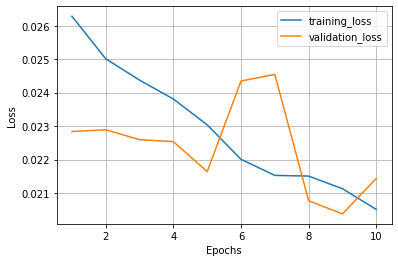

In [44]:
epochs = np.arange(10) + 1 
plt.plot(epochs,train_loss,label = "training_loss")
plt.plot(epochs,val_loss,label = "validation_loss")
plt.legend()
plt.grid("off")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [48]:
class FacesTest(Dataset):
  def __init__(self,df):
    super(Faces).__init__()

    self.df = df
    self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
  def __len__(self):
    return len(self.df)

  def preprocess_input(self,img):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    img = img.to(device)
    return img

  def load_img(self,ix):
    img = cv2.imread("./P1_Facial_Keypoints/data/test/"+self.df.iloc[ix,0])[:,:,::-1] /255.
    img = cv2.resize(img,(224,224)) 
    return img

  def __getitem__(self,ix):
    img = cv2.imread("./P1_Facial_Keypoints/data/test/"+self.df.iloc[ix,0]) / 255.
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)

    return img,kp2

In [49]:
test_df = pd.read_csv("/content/P1_Facial_Keypoints/data/test_frames_keypoints.csv")
testfaces_dataset = Faces(test_df.reset_index(drop = True))
testfaces_loader = DataLoader(testfaces_dataset,batch_size = 32)


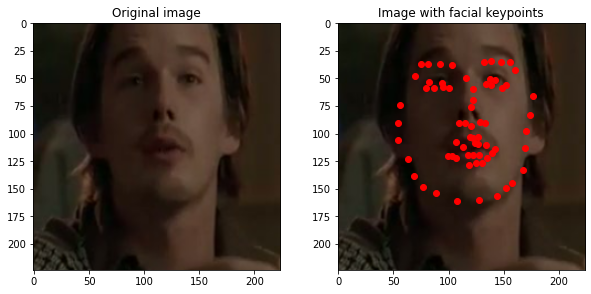

In [91]:
ix = 467
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = testfaces_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = testfaces_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu() #x[None].shape adds batch
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()


# Keypoint Detection with Pretrained Model

In [60]:
!pip install -qU face-alignment

In [62]:
import face_alignment

In [63]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,flip_input = False,device = "cuda")

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


In [81]:
input = cv2.imread("/content/P1_Facial_Keypoints/data/test/Conan_OBrien_51.jpg")
preds = fa.get_landmarks(input)[0]
print(preds.shape)

(68, 2)


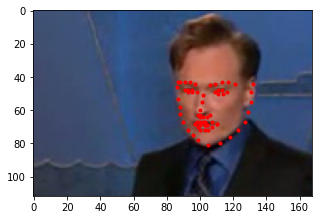

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(5,5))
plt.imshow(input[:,:,::-1]) #BGR to RGB
ax.scatter(preds[:,0], preds[:,1], marker='.', c='r')
plt.show()